In [1]:
import numpy as np
import os 
import sys
import pickle
from sklearn.decomposition import PCA
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.models import resnet18
from torchvision.transforms import Compose, ToTensor, Resize
from typing import Union
from tqdm import tqdm


In [2]:
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset

In [3]:
!nvidia-smi

Sat Sep 28 16:14:51 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:06:00.0 Off |                    0 |
|  0%   39C    P0    58W / 300W |      0MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Camelyon17 Training

We proceed in steps: 
- Split the Camelyon17 dataset into different splits corresponding to different iid/ood settings.
- Train and validate on the train/id_val split, while reporting OOD-performance on the test set to assess some model degradation.
- Extract features with the newly trained resnet and ship it out.




In [14]:
torch.backends.cudnn.enabled = True

learning_rate=1e-4
batch_size=64
epochs=100

In [4]:
import multiprocessing
from torchvision.models import resnet18, ResNet18_Weights, ResNet
from torch.utils.data import DataLoader

In [5]:
dataset = Camelyon17Dataset(root_dir='/scratch/ssd004/scratch/opent03/', download=False)
splits = ['train', 'id_val', 'val', 'test']
datasets = {}
dataloaders = {}
for split in splits:
    datasets[split] = dataset.get_subset(split=split, transform=ToTensor())
    #dataloaders[split] = torch.utils.data.DataLoader(datasets[split], batch_size=batch_size, num_workers=20, pin_memory=True)

#### Take Camelyon17 data splits and add to custom datasets

In [21]:
def load_memory(dataset):
    i = 0
    img_size = (3, 96, 96)
    num_images = len(dataset)
    stacked_images = torch.empty((num_images, *img_size))
    labels = torch.empty((num_images))
    for torch_img, label, _ in tqdm(dataset):
        stacked_images[i] = torch_img
        labels[i] = label
        i += 1
    return stacked_images, labels
        

In [23]:
datasets_memory = {}
for split in splits:
    datasets_memory[split] = load_memory(datasets[split])

100%|██████████| 85054/85054 [02:44<00:00, 518.27it/s]


In [24]:
class CudaDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images.cuda()
        self.labels = labels.cuda()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [ ]:
cuda_datasets = {}
for split in tqdm(splits):
    images, labels = datasets_memory[split]
    cuda_datasets[split] = CudaDataset(images, labels)

In [74]:
trainloader = DataLoader(cuda_datasets['train'], batch_size=batch_size, shuffle=True)
valloader = DataLoader(cuda_datasets['id_val'], batch_size=batch_size, shuffle=True)

In [6]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 1)

In [76]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [77]:
device = torch.device('cuda:0')
model = model.to(device)

In [92]:
def train(model, loader, criterion, optimizer):
    # Train
    model.train()
    for imgs, labels in tqdm(loader):
        #imgs, labels = imgs.cuda(non_blocking=True), labels.cuda(non_blocking=True).float()
        output = model(imgs).squeeze(-1)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
def evaluate(model, loader, on_cuda=True):
    # IID eval
    model.eval()
    count = 0
    acc = 0
    with torch.no_grad():
        for imgs, labels, in tqdm(loader):
            if not on_cuda:
                imgs, labels = imgs.cuda(), labels.cuda()
            output = F.sigmoid(model(imgs).squeeze(-1))
            preds = torch.round(output)
            acc += torch.sum(preds == labels)
            count += len(labels)
    acc = (acc/count).item()
    return acc    

In [83]:
patience = 0
best = 0
best_state_dict = None
model = model.cuda()
for epoch in range(epochs):
    print('Running epoch {}...'.format(epoch + 1))
    train(model, trainloader, criterion, optimizer)
    iid_acc = evaluate(model, valloader)
    #ood_acc = evaluate(model, dataloaders['val'])
    if iid_acc > best:
        best = iid_acc
        best_state_dict = model.state_dict().copy()
        patience = 0
    else:
        patience += 1
    print('iid: {},\tood: {}'.format(iid_acc, iid_acc))
    if patience > 5:
        print('Max patience reached! Returning...')
        break    
        

Running epoch 1...


100%|██████████| 525/525 [00:01<00:00, 266.98it/s]


tensor(33223, device='cuda:0')
33560
iid: 0.9899582862854004,	ood: 0.9899582862854004
Running epoch 2...


100%|██████████| 525/525 [00:01<00:00, 285.79it/s]


tensor(33322, device='cuda:0')
33560
iid: 0.992908239364624,	ood: 0.992908239364624
Running epoch 3...


 20%|██        | 958/4726 [00:11<00:45, 83.25it/s]


KeyboardInterrupt: 

In [90]:
val_ood_loader = DataLoader(datasets['val'], batch_size=64, shuffle=True)

In [95]:
evaluate(model, val_ood_loader, on_cuda=False)

100%|██████████| 546/546 [00:52<00:00, 10.33it/s]


0.8876059651374817

In [94]:
model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [114]:
del cuda_datasets['train'].labels
del cuda_datasets['id_val'].labels
torch.cuda.empty_cache()

In [115]:
!nvidia-smi

Sat Sep 28 16:12:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:06:00.0 Off |                    0 |
|  0%   38C    P0    86W / 300W |  41934MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get representation

In [7]:
model.load_state_dict(torch.load('resnet18_camelyon17.pth'))

<All keys matched successfully>

In [8]:
model = model.cuda()

In [32]:
def get_rep(model, dataset):
    # Takes in raw camelyon17 data
    model = model.cuda()
    model.eval()
    new_data = []
    labels_list = []
    loader = DataLoader(dataset, batch_size=2048, shuffle=True)
    for images, labels, _ in tqdm(loader):
        images = images.cuda()
        labels_list.append(labels)
        rep = model(images) # should be [1024, 512, 1, 1]
        rep = rep.squeeze(-1).squeeze(-1)# should be [1024, 512]
        new_data.append(rep.cpu().detach().numpy())
    np_data = np.concatenate(new_data, axis=0)
    np_labels = np.concatenate(labels_list)
    return np_data, np_labels

In [33]:
rep_model = torch.nn.Sequential(*list(model.children())[:-1])

In [34]:
x_train, y_train = get_rep(rep_model, datasets['train'])
x_idval, y_idval = get_rep(rep_model, datasets['id_val'])
x_val, y_val = get_rep(rep_model, datasets['val'])
x_test, y_test = get_rep(rep_model, datasets['test'])


100%|██████████| 42/42 [02:09<00:00,  3.09s/it]


(302436, 512)

In [125]:
torch.save(best_state_dict, 'baselines/resnet18_camelyon17.pth')

In [36]:
processed_data = {
    'x_train': x_train,
    'x_idval': x_idval,
    'x_val': x_val,
    'x_test': x_test
}
processed_labels = {
    'y_train': y_train,
    'y_idval': y_idval,
    'y_val': y_val,
    'y_test': y_test
}

In [45]:
with open('baselines/data/camelyon17_features.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

In [46]:
with open('baselines/data/camelyon17_labels.pkl', 'wb') as f:
    pickle.dump(processed_labels, f)

In [6]:
from sklearn.decomposition import PCA

def load_and_process_camelyon17(n_components=20):
    with open('baselines/data/camelyon17_features.pkl', 'rb') as f:
        datadict = pickle.load(f)
    with open('baselines/data/camelyon17_labels.pkl', 'rb') as f:
        labelsdict = pickle.load(f)
    
    pca = PCA(n_components=n_components)
    pca.fit(datadict['x_train'])
    x_train, x_test = pca.transform(datadict['x_train']), pca.transform(datadict['x_test'])
    y_train, y_test = labelsdict['y_train'], labelsdict['y_test']
    return x_train, x_test, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test = load_and_process_camelyon17()

In [35]:
from baselines.divergence import Divergence, permutation_test
distance = Divergence(name='h')

In [36]:
flag, distr, est = permutation_test(distance, X=x_train, Y=x_test, perms=500, enable_tqdm=True, max_size=50)

100%|██████████| 500/500 [00:02<00:00, 246.80it/s]


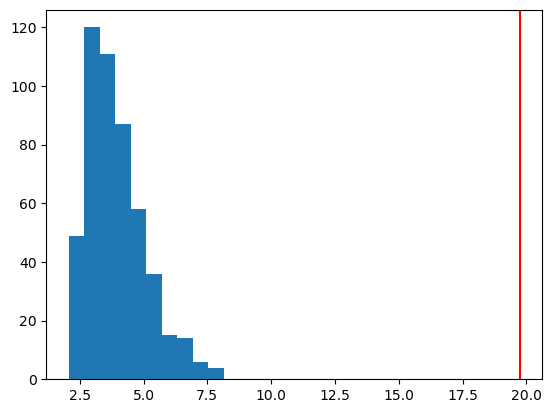

In [37]:
import matplotlib.pyplot as plt
plt.hist(distr)
plt.axvline(est, c='r')

In [29]:
flag

1